# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings('ignore')

# Make a dataset from different datasets to overcome unbalanced calsses

In [12]:
import os
import shutil
import random

# مسارات مجموعات البيانات المختلفة
datasets_dirs = [
    "/kaggle/input/chest-xray-pneumonia/chest_xray/val"]

# مسارات الفئات المطلوبة
merged_dataset_dir = "/kaggle/working/balance_dataset"
normal_dir = os.path.join(merged_dataset_dir, "Normal")


# نقل الصور
for dataset_dir in datasets_dirs:
    # تعديل المسارات لتناسب أسماء الفئات في كل Dataset
    normal_images_dir = os.path.join(dataset_dir, "NORMAL")
    
    # نسخ صور Normal
    for image_name in os.listdir(normal_images_dir):
        src_path = os.path.join(normal_images_dir, image_name)
        dest_path = os.path.join(normal_dir, image_name)
        shutil.copy(src_path, dest_path)

print("Images copied successfully!")


Images copied successfully!


# New dataset info.

In [14]:
from collections import Counter

# عرض أسماء الفئات
print("Train Classes:", train_data.classes)
print("Test Classes:", test_data.classes)

# حساب عدد الصور في كل فئة لمجموعة التدريب
train_class_counts = Counter([train_data.targets[i] for i in range(len(train_data))])
for class_name, count in zip(train_data.classes, train_class_counts.values()):
    print(f"Train Class '{class_name}': {count} images")

# حساب عدد الصور في كل فئة لمجموعة الاختبار
test_class_counts = Counter([test_data.targets[i] for i in range(len(test_data))])
for class_name, count in zip(test_data.classes, test_class_counts.values()):
    print(f"Test Class '{class_name}': {count} images")


Train Classes: ['Normal', 'Pneumonia']
Test Classes: ['NORMAL', 'PNEUMONIA']
Train Class 'Normal': 3697 images
Train Class 'Pneumonia': 3875 images
Test Class 'NORMAL': 234 images
Test Class 'PNEUMONIA': 390 images


# Data & Model preparations

In [13]:
# Lists for storing accuracies
train_accuracies = []
test_accuracies = []

# Data Augmentation
transform = transforms.Compose([             # Compose عشان ينفذ كل التحويلات دي مع بعض على كل صورة
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=3, sigma=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


# Dataset and Mini-Batches
train_dir = '/kaggle/working/balance_dataset'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# ResNet18, Creating new output layer, and Dropout
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(                     # Sequential عشان ينفذ الأمرين دول ورا بعض
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2))   # Creating new output layer with 2 outputs and the same no. of inputs 


# Full Fine-Tuning
for param in model.parameters():     
    param.requires_grad = True


# Move the model to GPU or CPU
device = torch.device("cuda")
model = model.to(device)


# Loss Function, Optimizer, and Learning Rate decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Fitting

In [15]:
# Model Training
num_epochs = 20
for epoch in range(num_epochs):
    model.train()                                     # Put the model in training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)     # Images & Labels must be on the same device in PyTorch, GPU or CPU
        optimizer.zero_grad()                                    # make Gradient=0 at the begining of every batch عشان ميحصلش مشاكل في حساب الاوزان
        outputs = model(images)                                 # Forward Propagation
        loss = criterion(outputs, labels)                       # Error estimation
        loss.backward()                                         # Backward Propagation
        optimizer.step()                                        # Update Weights
        running_loss += loss.item()                            # loss.item() => Error of current mini-batch
    
    # Number of Total and Correct Answers
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    scheduler.step()                                        # increase 't' in StepLR equation
    
    # Training Accuracy
    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

Epoch [1/20], Loss: 0.1572, Training Accuracy: 94.08%
Epoch [2/20], Loss: 0.1058, Training Accuracy: 96.28%
Epoch [3/20], Loss: 0.0959, Training Accuracy: 96.67%
Epoch [4/20], Loss: 0.0926, Training Accuracy: 96.67%
Epoch [5/20], Loss: 0.0882, Training Accuracy: 96.83%
Epoch [6/20], Loss: 0.0835, Training Accuracy: 97.20%
Epoch [7/20], Loss: 0.0742, Training Accuracy: 97.41%
Epoch [8/20], Loss: 0.0475, Training Accuracy: 98.38%
Epoch [9/20], Loss: 0.0386, Training Accuracy: 98.68%
Epoch [10/20], Loss: 0.0370, Training Accuracy: 98.81%
Epoch [11/20], Loss: 0.0314, Training Accuracy: 98.90%
Epoch [12/20], Loss: 0.0288, Training Accuracy: 98.98%
Epoch [13/20], Loss: 0.0269, Training Accuracy: 99.08%
Epoch [14/20], Loss: 0.0237, Training Accuracy: 99.22%
Epoch [15/20], Loss: 0.0221, Training Accuracy: 99.21%
Epoch [16/20], Loss: 0.0197, Training Accuracy: 99.42%
Epoch [17/20], Loss: 0.0204, Training Accuracy: 99.33%
Epoch [18/20], Loss: 0.0184, Training Accuracy: 99.39%
Epoch [19/20], Loss

# Evaluating

In [16]:
# Model Evaluating
for epoch in range(num_epochs):
    model.eval()              # Put the model in evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                                   # Forward Propagation
            _, predicted = torch.max(outputs, 1)        # (_ = logits of the image) and (predicted = index of the selected class)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    test_accuracies.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.2f}%")


# Saving trainde weights
torch.save(model.state_dict(), "pneumonia_model_by_team10.pth")
print("Model saved successfully.")

Test Accuracy: 95.51%
Test Accuracy: 95.99%
Test Accuracy: 95.67%
Test Accuracy: 95.83%
Test Accuracy: 96.15%
Test Accuracy: 95.67%
Test Accuracy: 95.67%
Test Accuracy: 95.51%
Test Accuracy: 95.35%
Test Accuracy: 95.51%
Test Accuracy: 95.67%
Test Accuracy: 96.31%
Test Accuracy: 95.03%
Test Accuracy: 95.35%
Test Accuracy: 95.51%
Test Accuracy: 95.67%
Test Accuracy: 95.83%
Test Accuracy: 95.19%
Test Accuracy: 95.35%
Test Accuracy: 95.67%
Model saved successfully.


# Plotting Train-Test accuracy graph to ensure that the model is in genaralizing well

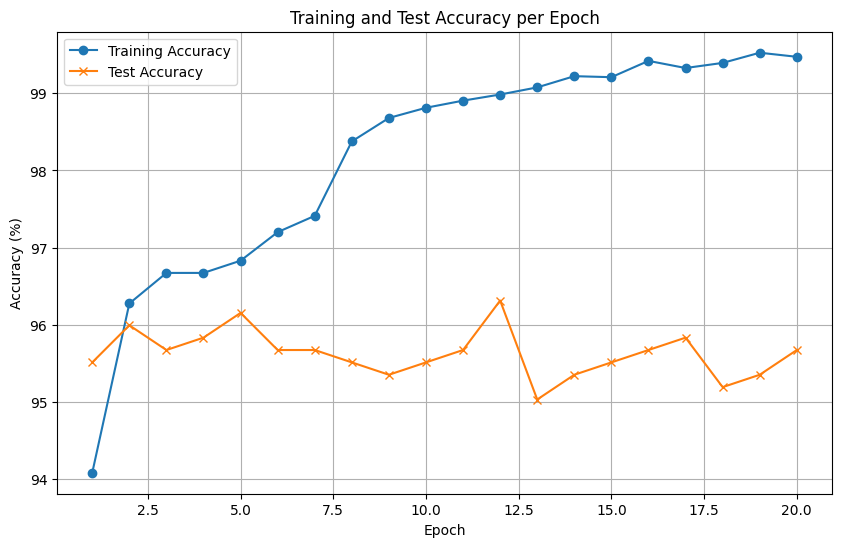

In [22]:
# رسم الرسم البياني للـ Training Accuracy والـ Test Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='x')
plt.title('Training and Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()